# ML in Cybersecurity: Project III

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: Hasan Md Tusfiqur Alam (s8haalam@stud.uni-saarland.de), name2 (email2), ...*
  * **Tutor**: *fill this in*


## Logistics
  * **Due date**: 12th December 2019, 13:59:59 
  * Email the completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 28-Nov-2019: Project 3 hand-out
  * **12-Dec-2019** (13:59:59): Email completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland

  * 19-Dec-2019: Project 3 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [2]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [3]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision

In [4]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [5]:
def identity_func(foo):
    return foo

#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

In [6]:
#
#
# ------- Your Code -------
#
#

# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train
# (5)evaluate
# print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

In [7]:
batch_size_train = 64 
batch_size_test = 1000 
n_epochs = 12
learning_rate = 0.01
momentum = 0.5

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])), batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                              ])), batch_size=batch_size_test, shuffle=True)



In [8]:
class Net(nn.Module):

    def __init__(self,kernels=5):
        super(Net, self).__init__()
        # 1 input image channel, 10 output channels, 5x5 square convolution
        # kernel 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=kernels)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=kernels)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
def train(n_epochs):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))

            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
            torch.save(net.state_dict(), 'model_3.pth')
    train_losses.append(loss.item()) 

In [10]:
def test():
    net.eval()
    test_loss = 0 
    correct = 0 
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 
            100. * correct / len(test_loader.dataset)))

In [11]:
train_losses = []
train_counter = []
test_losses = []
train_accuracies = []
test_accuracies = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
net = Net()
optimizer = optim.SGD(net.parameters(), lr= learning_rate, momentum=momentum)

for epoch in range(1, n_epochs):
    train(epoch)
    test()

/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298018
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.274852
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.200943
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.524652
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.116047
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.078699
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.617429
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.582687
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.626827
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.827809


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2996, Accuracy: 9143/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.401582
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.667945
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.506460
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.482498
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.430197
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.341038
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.390894
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.465890
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.334937
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.342088

Test set: Avg. loss: 0.1849, Accuracy: 9423/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.410148
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.272098
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.463480
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.293113
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.434151
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.479218
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.285207
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.280

In [12]:
# net.save_state_dict('best_model.pt')
torch.save(net.state_dict(), 'best_model.pt')

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [13]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test_fgsm( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 1000):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 1000:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
model = Net()
model.load_state_dict(torch.load('best_model.pt'), strict=False)

<All keys matched successfully>

In [87]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                              ])), batch_size=1, shuffle=False)


In [88]:

epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0	Test Accuracy = 9015 / 10000 = 0.9015
Epsilon: 0.05	Test Accuracy = 8636 / 10000 = 0.8636
Epsilon: 0.1	Test Accuracy = 7918 / 10000 = 0.7918
Epsilon: 0.15	Test Accuracy = 6810 / 10000 = 0.681
Epsilon: 0.2	Test Accuracy = 5307 / 10000 = 0.5307
Epsilon: 0.25	Test Accuracy = 3783 / 10000 = 0.3783
Epsilon: 0.3	Test Accuracy = 2544 / 10000 = 0.2544
Epsilon: 0.4	Test Accuracy = 1060 / 10000 = 0.106
Epsilon: 0.5	Test Accuracy = 583 / 10000 = 0.0583


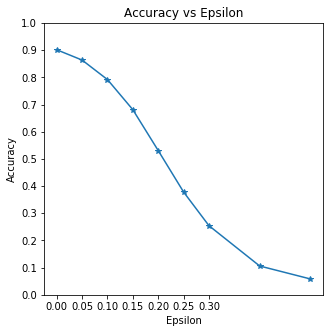

In [89]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [90]:
#
#
# ------- Your Code -------
#
#
acc, ex = test_fgsm(model, device, test_loader, 0.3)
print(type(ex[0][0]))

/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.3	Test Accuracy = 2491 / 10000 = 0.2491
<class 'int'>


### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

KeyboardInterrupt: 

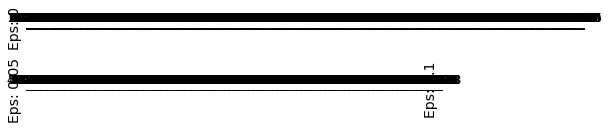

In [91]:
#
#
# ------- Your Code -------
#
#
cnt = 0
plt.figure(figsize=(10,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [ ]:
#
#
# ------- Your Code -------
#
#

# (a) attack 1
# (b) attack 2

!pip install foolbox

In [114]:
# (a) attack 1


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                              ])), batch_size=1, shuffle=False)
import foolbox
import torchvision.models as models
model = Net()
model.load_state_dict(torch.load('best_model.pt'),strict=False)
print(model)
# instantiate model (supports PyTorch, Keras, TensorFlow (Graph and Eager), JAX, MXNet and many more)
fmodel = foolbox.models.PyTorchModel(model, bounds= (0,1), num_classes=10)

# get a batch of images and labels and print the accuracy
# -> 0.9375

images = np.expand_dims(images, axis=1)

attack = foolbox.attacks.GradientSignAttack(fmodel)
i = 0
adversarials_GSA = []
for index, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    data, target = data.data.numpy(), target.data.numpy()
    adversarials_GSA.append(attack(data, target).squeeze())
    if index >= 9:
        break
    i = i + 1

print(len(adversarials_GSA))

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/foolbox/models/pytorch.py:71: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10


In [115]:
import foolbox
import torchvision.models as models
model = Net()
model.load_state_dict(torch.load('best_model.pt'),strict=False)
print(model)
# instantiate model (supports PyTorch, Keras, TensorFlow (Graph and Eager), JAX, MXNet and many more)
fmodel = foolbox.models.PyTorchModel(model, bounds= (0,1), num_classes=10)

# get a batch of images and labels and print the accuracy
images, labels = foolbox.utils.samples(dataset= 'mnist', batchsize=10, data_format='channels_first', bounds=(0, 1))
#print(np.mean(fmodel.forward(images).argmax(axis=-1) == labels))
# -> 0.9375

attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel, distance=foolbox.distances.Linf)


i = 0
adversarials_CWA = []
for index, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    data, target = data.data.numpy(), target.data.numpy()
    adversarials_CWA.append(attack(data, target).squeeze())
    if index >= 9:
        break
print(len(adversarials_CWA))



Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/foolbox/models/pytorch.py:71: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10


In [116]:
# Original image
original_images = []
original_class = []
for index, (data, target)  in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    data, target = data.data.numpy(), target.data.numpy()
    data, target = data.squeeze(), target
    original_images.append(data)
    original_class.append(target)
    if index >= 9:
        break



print(len(original_images))

10


### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


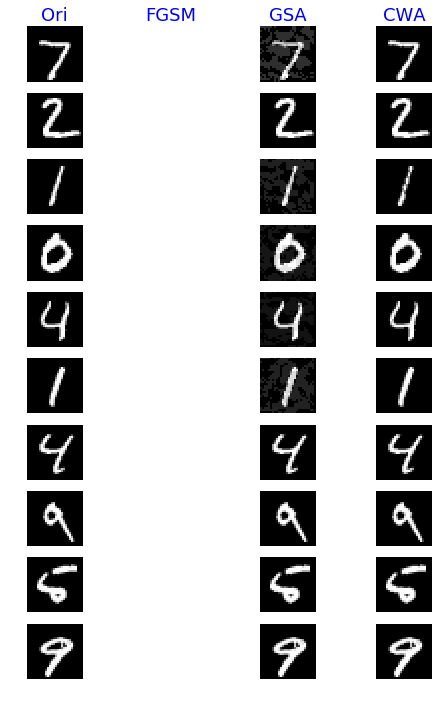

In [118]:
#
#
# ------- Your Code -------
#
#

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Ori','FGSM','GSA', 'CWA'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(original_images[i])
    #axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adversarials_GSA[i])
    axes[i,3].imshow(adversarials_CWA[i])
                  

Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?
* How different is the adversarial sample from the original image?
(L0,L2,Linf norm)  
* How about the computation cost of each attack method?
* Does the attack require white-box access to the model?
* .....

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

In [0]:
#
#
# ------- Your Code -------
#
#
print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend)

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* What did you try to make the classifier more robust against FGSM? 
* Why did it work? 
* Is the classifier now robust against FGSM?  
* ...

Feel free to state any interesting finding you encountered during this project.